In [ ]:
# ── Cell 1: Initialization & Imports ─────────────────────────────────
# Enable auto-reload so changes to derivatives.py are picked up without restarting the kernel.
%load_ext autoreload
%autoreload 2

# Standard libraries
import datetime
import numpy as np
import pandas as pd
import yfinance as yf

# Import our option classes (with full Greeks) from derivatives.py
from derivatives import Share, EuropeanCall, AmericanPut, BarrierOption, BasketCall


print("✅ Loaded derivatives.py and core libraries.")

tickers = ["BHP.AX", "CBA.AX", "WES.AX", "CSL.AX", "WDS.AX", "MQG.AX"]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] No such file or directory: './project_folder/f17hist.xlsx'

In [2]:
# ── Cell 2: Spot Prices & Discount Function ─────────────────────────
# Fetch ASX closing prices for our tickers on the trade date
trade_date = "2025-05-16"

# Define a flat-curve discount function (5% p.a.) as placeholder
r        = 0.05
discount = lambda t: np.exp(-r * t)


In [3]:
# ── Cell 3: Realised Volatility Calculation ─────────────────────────
# Download 1 year of historical closes to compute realised vols
hist = yf.download(tickers, end=trade_date, period="1y", progress=False)["Close"]
rets = hist.pct_change().dropna()                # daily returns
vol  = (rets.std() * np.sqrt(252)).to_dict()     # annualised vol σ√252

print("Realised vols (annualised):")
for tkr, σ in vol.items():
    print(f"  {tkr:7s}: {σ:.2%}")


YF.download() has changed argument auto_adjust default to True


Realised vols (annualised):
  BHP.AX : 22.52%
  CBA.AX : 21.39%
  CSL.AX : 19.03%
  MQG.AX : 24.82%
  WDS.AX : 29.25%
  WES.AX : 20.30%


In [4]:
### ── Cell 4: Option Instantiation & Pricing ──────────────────────────


import numpy as np
import pandas as pd

trade_date = "2025-05-16"

# Share objects
bhp_share = Share("BHP.AX", trade_date)
cba_share = Share("CBA.AX", trade_date)
wes_share = Share("WES.AX", trade_date)
csl_share = Share("CSL.AX", trade_date)
wds_share = Share("WDS.AX", trade_date)
mqg_share = Share("MQG.AX", trade_date)

# Helper for year fraction
def year_frac(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)).days / 365

# Instantiate options
T1 = year_frac(trade_date, "2027-09-15")
bhp = EuropeanCall(
    Share    = bhp_share,
    K        = 0.98 * bhp_share.get_price(),
    T        = T1,
    discount = discount
)

T2 = year_frac(trade_date, "2026-05-15")
cba = AmericanPut(
    Share    = cba_share,
    K        = 170.0,
    T        = T2,
    discount = discount
)

wes = BarrierOption(
    Share    = wes_share,
    K        = 80.0,
    T        = T1,
    discount = discount,
    barrier  = 100.0
)

T3 = year_frac(trade_date, "2025-07-17")
basket_shares = [bhp_share, csl_share, wds_share, mqg_share]

weights = np.array([0.10, 0.35, 0.15, 0.40])

basket = BasketCall(
    share_list = basket_shares,
    weights    = weights,
    K          = 175.0,
    T          = T3,
    discount   = discount,
    corr       = np.identity(4),
    paths      = 50000
)


# --------- Calculate Prices & Greeks ---------

results = []
for name, obj in [
    ("BHP Euro Call", bhp),
    ("CBA Am Put",    cba),
    ("WES Barrier",   wes)
]:
    price = obj.price()
    delta = obj.delta()
    theta = obj.theta()
    vega = getattr(obj, "vega", lambda: np.nan)()  # only for classes with vega
    results.append((name, price, delta, theta, vega))

# Basket Call Greeks
basket_price = basket.price()
basket_partials = basket.delta()
basket_theta = basket.theta()
basket_vega  = basket.vega()

# compute portfolio weighted delta
basket_portfolio_delta = np.dot(weights, basket_partials)


# Print breakdown for hedging
basket_tickers = ["BHP", "CSL", "WDS", "MQG"]
print("Basket Call partial deltas (hedge ratio per asset):")
for i, ticker in enumerate(basket_tickers):
    print(f"  {ticker}: {basket_partials[i]:.4f} shares per basket call option")

print(f"Portfolio-weighted basket delta: {basket_portfolio_delta:.4f}")


# Optional: Print results
for r in results:
    print(f"{r[0]}: Price={r[1]:.4f}, Delta={r[2]:.4f}, Theta={r[3]:.4f}, Vega={r[4]:.4f}")


# Calculate normalized (per $1 move in the basket) delta:
basket_value = np.dot(weights, [s.get_price() for s in basket_shares])
basket_normalized_delta = np.dot(weights, basket_partials) / basket_value


print("Normalized basket delta (per $1 move in basket):", basket_normalized_delta)

results.append(("Basket Call", basket_price, basket_normalized_delta, basket_theta, basket_vega))

Basket Call partial deltas (hedge ratio per asset):
  BHP: -111.8587 shares per basket call option
  CSL: 89.8640 shares per basket call option
  WDS: -597.9334 shares per basket call option
  MQG: 297.6016 shares per basket call option
Portfolio-weighted basket delta: 49.6172
BHP Euro Call: Price=8.0113, Delta=0.7157, Theta=-2.0138, Vega=nan
CBA Am Put: Price=12.3417, Delta=-0.4354, Theta=-4.6117, Vega=nan
WES Barrier: Price=14.2683, Delta=0.7655, Theta=-4.9034, Vega=nan
Normalized basket delta (per $1 move in basket): 0.2837911458938042


In [5]:
# ── Cell 5: Results Summary ──────────────────────────────────────────
# Assemble into a DataFrame for clear presentation
import pandas as pd

df = pd.DataFrame(results, columns=["Trade", "Price", "Delta", "Theta", "Vega"]).set_index("Trade")
df


,Price,Delta,Theta,Vega
Trade,,,,
BHP Euro Call,8.011260,0.715655,-2.013821,NaN
CBA Am Put,12.341718,-0.435382,-4.611664,NaN
WES Barrier,14.268327,0.765479,-4.903363,NaN
Basket Call,4.953364,0.283791,11.994484,114.61523


In [6]:
# ── Cell 7: Narrative Hedge Summary ───────────────────────────────────

from IPython.display import Markdown, display

# Rebuild a small DataFrame from your `results` list
cols = ["Price","Delta","Theta","Vega"]
df_narr = (
    pd.DataFrame(results, columns=["Trade"] + cols)
      .set_index("Trade")
      .round(4)
)

# Compute hedge quantity = –Delta (i.e. short Δ to hedge)
df_narr["HedgeQty"] = (-df_narr["Delta"]).round(2)

def action(qty):
    return "buying" if qty > 0 else "selling"

# Start building the markdown text
text = "## Portfolio Hedge Summary\n\n"

# First three single‐stock/exotic legs
meta = {
    "BHP Euro Call":  ("BHP", "call"),
    "CBA Am Put":     ("CBA", "put"),
    "WES Barrier":    ("WES", "barrier call")
}

for trade, (ticker, ctype) in meta.items():
    row   = df_narr.loc[trade]
    act   = action(row.HedgeQty)
    text += (
        f"- **{trade}**  \n"
        f"  Price = **${row.Price:.4f}**, Δ = {row.Delta:.4f}, Vega = {row.Vega:.4f}, Theta = {row.Theta:.4f}  \n"
        f"  → Hedge by **{act}** {abs(row.HedgeQty):.2f} shares of {ticker} per {ctype}.\n\n"
    )

# Now the basket leg
brow   = df_narr.loc["Basket Call"]
bact   = action(brow.HedgeQty)
text += (
    f"- **Four-Stock Basket Call**  \n"
    f"  Price = **${brow.Price:.4f}**, Δ = {brow.Delta:.4f}, Vega = {brow.Vega:.4f}, Theta = {brow.Theta:.4f}  \n"
    f"  → Hedge basket by trading each underlying:  \n"
)

# Distribute across weights
weights = [0.10, 0.35, 0.15, 0.40]
tickers = ["BHP", "CSL", "WDS", "MQG"]
for w, t in zip(weights, tickers):
    sub_qty = (w * brow.HedgeQty).round(2)
    sub_act = action(sub_qty)
    text += f"    - **{sub_act}** {abs(sub_qty):.2f} shares of {t} (weight {int(w*100)}%)  \n"

display(Markdown(text))



## Portfolio Hedge Summary

- **BHP Euro Call**  
  Price = **$8.0113**, Δ = 0.7157, Vega = nan, Theta = -2.0138  
  → Hedge by **selling** 0.72 shares of BHP per call.

- **CBA Am Put**  
  Price = **$12.3417**, Δ = -0.4354, Vega = nan, Theta = -4.6117  
  → Hedge by **buying** 0.44 shares of CBA per put.

- **WES Barrier**  
  Price = **$14.2683**, Δ = 0.7655, Vega = nan, Theta = -4.9034  
  → Hedge by **selling** 0.77 shares of WES per barrier call.

- **Four-Stock Basket Call**  
  Price = **$4.9534**, Δ = 0.2838, Vega = 114.6152, Theta = 11.9945  
  → Hedge basket by trading each underlying:  
    - **selling** 0.03 shares of BHP (weight 10%)  
    - **selling** 0.10 shares of CSL (weight 35%)  
    - **selling** 0.04 shares of WDS (weight 15%)  
    - **selling** 0.11 shares of MQG (weight 40%)  


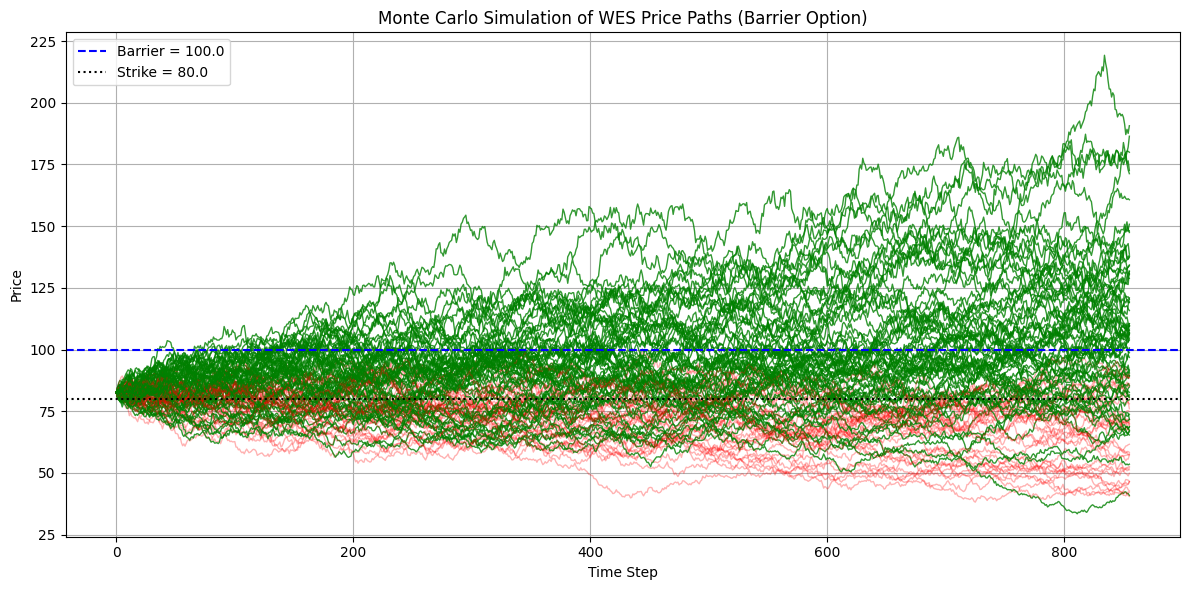

✅ 68 out of 100 paths crossed the barrier (knock-in).
In this notebook, I performed a Monte Carlo simulation of the stock price for WES.AX to model the behavior of a European up-and-in barrier call option. 
This type of option becomes active (knocks in) only if the asset price crosses a specified barrier level during the life of the option.

We can visually distinguish between knock-in and non-knock-in paths. The green trajectories represent valid payoff scenarios for the up-and-in option. 
A higher number of red paths suggests that the barrier is relatively high compared to the initial price, making knock-in less probable.


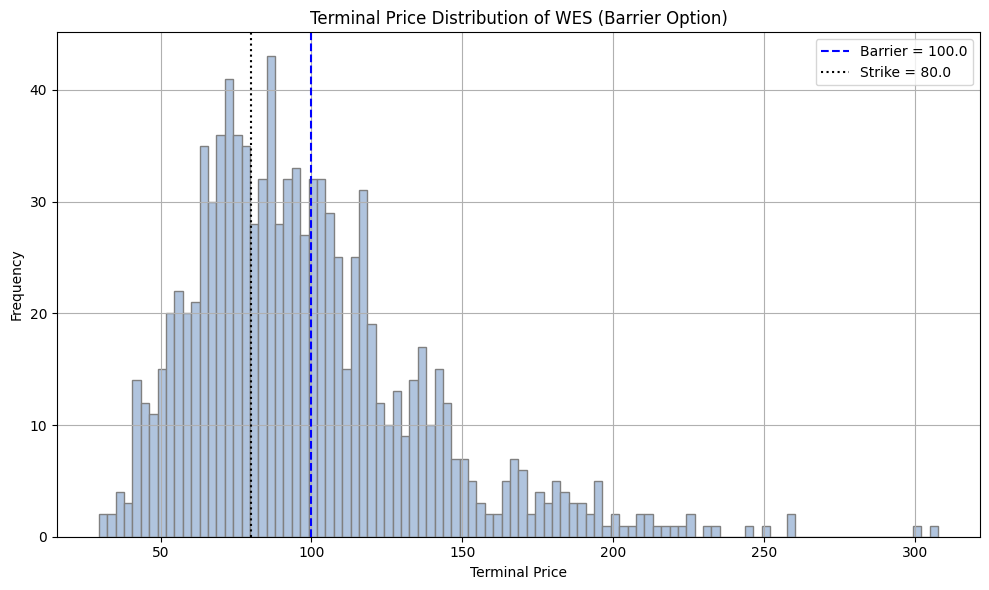

📊 Mean terminal price: 98.44
✅ Knock-in frequency: 69.00%
The histogram of terminal prices shows that the average (mean) simulated price of WES at maturity is approximately $98.44. 
This suggests that, under the risk-neutral measure, the asset is expected to appreciate moderately over the option's life. 
Additionally, the knock-in frequency of 69.00% indicates that a significant majority of simulated paths breached the barrier level of $100 at least once. 
This implies that the up-and-in barrier call option is fairly likely to become active, largely due to the moderate volatility and sufficient time for price movement in the simulation.


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_paths(S0, T, sigma, r, paths=100, steps=855, barrier=None):
    dt = T / steps
    S_paths = np.zeros((paths, steps + 1))
    S_paths[:, 0] = S0

    for t in range(1, steps + 1):
        z = np.random.standard_normal(paths)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    if barrier is not None:
        hit_barrier = (S_paths >= barrier).any(axis=1)
        return S_paths, hit_barrier
    else:
        return S_paths, None
    
S0 = {
    "WES.AX": 82.56 
}

vol = {
    "WES.AX": 0.2030  
}

T1 = 855 / 252  

r = 0.05
# Simulate paths for WES option
S0_wes   = S0["WES.AX"]
T_wes    = T1
σ_wes    = vol["WES.AX"]
barrier  = 100.0
strike   = 80.0

paths_data, hit_barrier = simulate_paths(S0_wes, T_wes, σ_wes, r, paths=100, barrier=barrier)

# Plot
plt.figure(figsize=(12, 6))
for i in range(paths_data.shape[0]):
    if hit_barrier[i]:
        plt.plot(paths_data[i], lw=1, alpha=0.8, color='green')
    else:
        plt.plot(paths_data[i], lw=1, alpha=0.3, color='red')

plt.axhline(barrier, color='blue', linestyle='--', label=f"Barrier = {barrier}")
plt.axhline(strike, color='black', linestyle=':', label=f"Strike = {strike}")
plt.title("Monte Carlo Simulation of WES Price Paths (Barrier Option)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
num_activated = hit_barrier.sum()
print(f"✅ {num_activated} out of {len(hit_barrier)} paths crossed the barrier (knock-in).")

print("""In this notebook, I performed a Monte Carlo simulation of the stock price for WES.AX to model the behavior of a European up-and-in barrier call option. 
This type of option becomes active (knocks in) only if the asset price crosses a specified barrier level during the life of the option.

We can visually distinguish between knock-in and non-knock-in paths. The green trajectories represent valid payoff scenarios for the up-and-in option. 
A higher number of red paths suggests that the barrier is relatively high compared to the initial price, making knock-in less probable.""")


# Simulate more paths for a stable histogram
paths_for_hist = 1000
steps = 855

terminal_paths, hit_barrier_hist = simulate_paths(S0_wes, T_wes, σ_wes, r, 
                                                  paths=paths_for_hist, 
                                                  steps=steps, 
                                                  barrier=barrier)

terminal_prices = terminal_paths[:, -1]

# Plot histogram of terminal prices
plt.figure(figsize=(10, 6))
plt.hist(terminal_prices, bins=100, color='lightsteelblue', edgecolor='gray')
plt.axvline(barrier, color='blue', linestyle='--', label=f"Barrier = {barrier}")
plt.axvline(strike, color='black', linestyle=':', label=f"Strike = {strike}")
plt.title("Terminal Price Distribution of WES (Barrier Option)")
plt.xlabel("Terminal Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Stats

mean_terminal = np.mean(terminal_prices)
knock_in_freq = np.mean(hit_barrier_hist) * 100

mean_terminal = np.mean(terminal_prices)
print(f"📊 Mean terminal price: {mean_terminal:.2f}")
print(f"✅ Knock-in frequency: {np.mean(hit_barrier_hist) * 100:.2f}%")
print(f"""The histogram of terminal prices shows that the average (mean) simulated price of WES at maturity is approximately ${mean_terminal:.2f}. 
This suggests that, under the risk-neutral measure, the asset is expected to appreciate moderately over the option's life. 
Additionally, the knock-in frequency of {knock_in_freq:.2f}% indicates that a significant majority of simulated paths breached the barrier level of $100 at least once. 
This implies that the up-and-in barrier call option is fairly likely to become active, largely due to the moderate volatility and sufficient time for price movement in the simulation.""")



Correlation matrix between companies:
        BHP.AX  CSL.AX  MQG.AX  WDS.AX
BHP.AX    1.00    0.60    0.55    0.50
CSL.AX    0.60    1.00    0.65    0.40
MQG.AX    0.55    0.65    1.00    0.45
WDS.AX    0.50    0.40    0.45    1.00


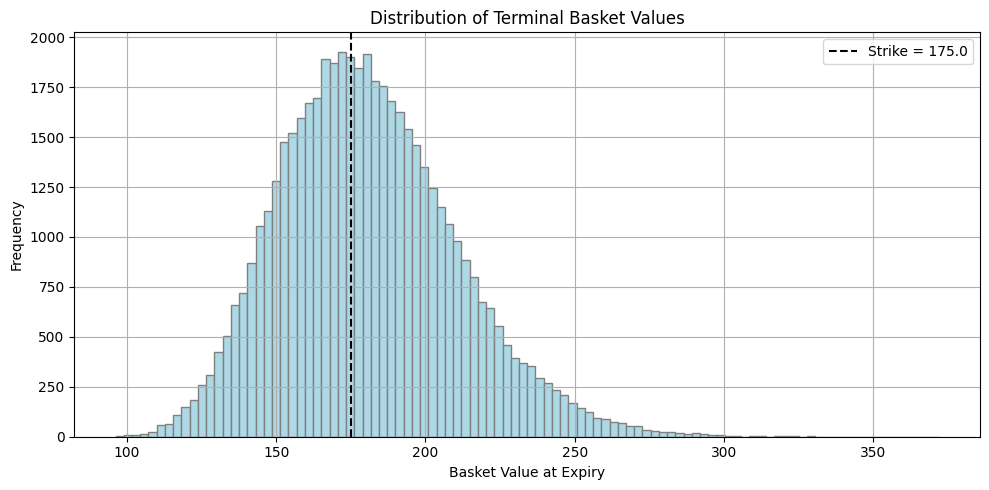


🔹 Mean terminal basket value: 180.88
The first histogram shows the distribution of the terminal values of the weighted basket composed of BHP, CSL, MQG, and WDS. 
Most simulations cluster around the mean terminal value, which is approximately $180.88. The black dashed line marks the strike price of $175. 
Paths ending to the right of this line result in a positive payoff, while those to the left expire worthless. Here, as the average terminal value is greater than the strike price, the basket option is on average expected to finish in-the-money at expiry.


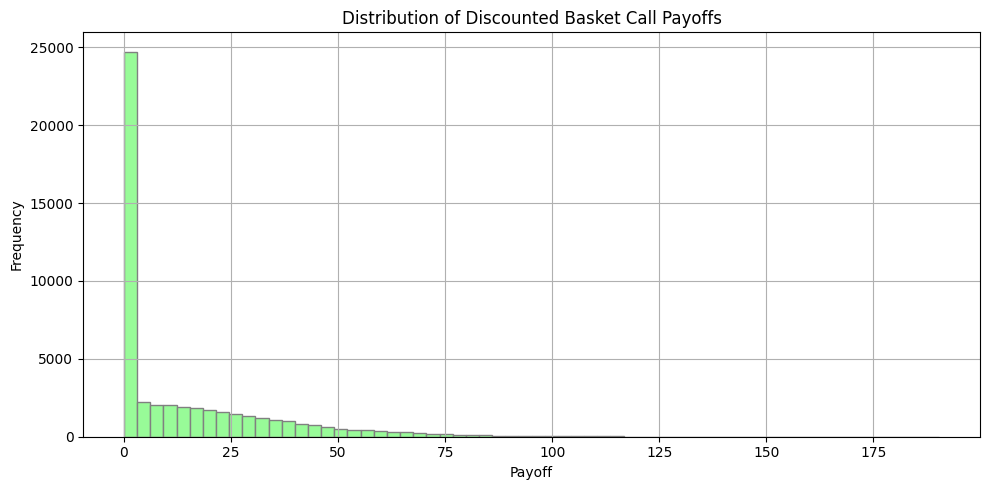

🔸 Probability ITM (payoff > 0): 54.90%
💵 Mean discounted payoff (Option Price): 14.2534
The second histogram illustrates the distribution of the discounted payoffs of the basket call option.
It shows the frequency and magnitude of in-the-money outcomes. A noticeable portion of the area within the first bar, with a probability of 54.90% for finishing in-the-money.
The average discounted payoff—representing the estimated option price is 14.2534.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters and inputs
np.random.seed(42)
steps = 62
paths = 50000
T = 175 / 252  # Convert 175 trading days to years assuming 252 trading days per year
dt = T / steps
r = 0.05  # Flat risk-free rate 5%

# Company names
companies = ['BHP.AX', 'CSL.AX', 'MQG.AX', 'WDS.AX']

# Spot prices
S0s = np.array([39.72, 241.82, 207.35, 21.92])

# Volatility from previous calculations
σs = np.array([0.2254, 0.1903, 0.2482, 0.2925])  

# Correlation matrix 
corr = np.array([
    [1.00, 0.60, 0.55, 0.50],
    [0.60, 1.00, 0.65, 0.40],
    [0.55, 0.65, 1.00, 0.45],
    [0.50, 0.40, 0.45, 1.00]
])

# Weights in the basket (sum to 1)
weights = np.array([0.10, 0.35, 0.40, 0.15])

# Strike price
K = 175.0

# Discount factor function
def discount(T):
    return np.exp(-r * T)

# Cholesky decomposition for correlation matrix
L = np.linalg.cholesky(corr)

# Generate correlated random paths
Z = np.random.normal(size=(paths, steps, len(companies)))
Z_corr = Z @ L.T

# Initialise asset paths array
S_paths = np.zeros((paths, steps + 1, len(companies)))
S_paths[:, 0, :] = S0s

# Simulate GBM paths for each asset
for t in range(1, steps + 1):
    S_paths[:, t, :] = S_paths[:, t - 1, :] * np.exp(
        (r - 0.5 * σs**2) * dt + σs * np.sqrt(dt) * Z_corr[:, t - 1, :]
    )

# Compute terminal basket values and option payoffs
terminal_values = np.dot(S_paths[:, -1, :], weights)
payoffs = np.maximum(terminal_values - K, 0)
discounted_payoffs = discount(T) * payoffs

# Print correlation matrix as a table
corr_df = pd.DataFrame(corr, index=companies, columns=companies)
print("Correlation matrix between companies:")
print(corr_df.round(4))

# Plot 1: Distribution of terminal basket values
plt.figure(figsize=(10, 5))
plt.hist(terminal_values, bins=100, color='lightblue', edgecolor='gray')
plt.axvline(K, color='black', linestyle='--', label=f"Strike = {K}")
plt.title("Distribution of Terminal Basket Values")
plt.xlabel("Basket Value at Expiry")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n🔹 Mean terminal basket value: {terminal_values.mean():.2f}")

print(f"""The first histogram shows the distribution of the terminal values of the weighted basket composed of BHP, CSL, MQG, and WDS. 
Most simulations cluster around the mean terminal value, which is approximately ${terminal_values.mean():.2f}. The black dashed line marks the strike price of $175. 
Paths ending to the right of this line result in a positive payoff, while those to the left expire worthless. Here, as the average terminal value is greater than the strike price, the basket option is on average expected to finish in-the-money at expiry.""")

# Plot 2: Distribution of option payoffs
plt.figure(figsize=(10, 5))
plt.hist(discounted_payoffs, bins=62, color='palegreen', edgecolor='gray')
plt.title("Distribution of Discounted Basket Call Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print summary stats
print(f"🔸 Probability ITM (payoff > 0): {(payoffs > 0).mean():.2%}")
print(f"💵 Mean discounted payoff (Option Price): {discounted_payoffs.mean():.4f}")
print(f"""The second histogram illustrates the distribution of the discounted payoffs of the basket call option.
It shows the frequency and magnitude of in-the-money outcomes. A noticeable portion of the area within the first bar, with a probability of {(payoffs > 0).mean():.2%} for finishing in-the-money.
The average discounted payoff—representing the estimated option price is {discounted_payoffs.mean():.4f}.""")
